### Libraries

In [2]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import datetime64
import seaborn as sns
import csv
import tensorflow as tf
from tensorflow import keras
import holidays
from sklearn import preprocessing
import xgboost
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import lightgbm as ltb
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_absolute_error

In [4]:
mtltrans = pd.read_csv("../data/splitdates.csv")

In [5]:
mtltrans.head()

,Unnamed: 0,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14,0,3
1,1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0,3
2,2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0,3
3,3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0,3
4,4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0,3


In [6]:
mtltrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77409 entries, 0 to 77408
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   77409 non-null  int64  
 1   ITEM_NUMBER  77409 non-null  int64  
 2   DATE         77409 non-null  object 
 3   TIME         77409 non-null  object 
 4   SOLDUNITS    77409 non-null  float64
 5   YEAR         77409 non-null  int64  
 6   MONTH        77409 non-null  int64  
 7   WEEK         77409 non-null  int64  
 8   DAY          77409 non-null  int64  
 9   IS_HOLIDAY   77409 non-null  int64  
 10  SEASON       77409 non-null  int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 6.5+ MB


In [7]:
df1, df2, df3 = [x for _, x in mtltrans.groupby(mtltrans['ITEM_NUMBER'])]

In [8]:
df1.head()

,Unnamed: 0,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON
0,0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14,0,3
1,1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0,3
2,2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0,3
3,3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0,3
4,4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0,3


In [9]:
def decompose_item_demand(df, share_type='SOLDUNITS', samples=250, period=24):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    
    #plot the complete time series
    fig, axs = plt.subplots(2, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    

    plt.show()

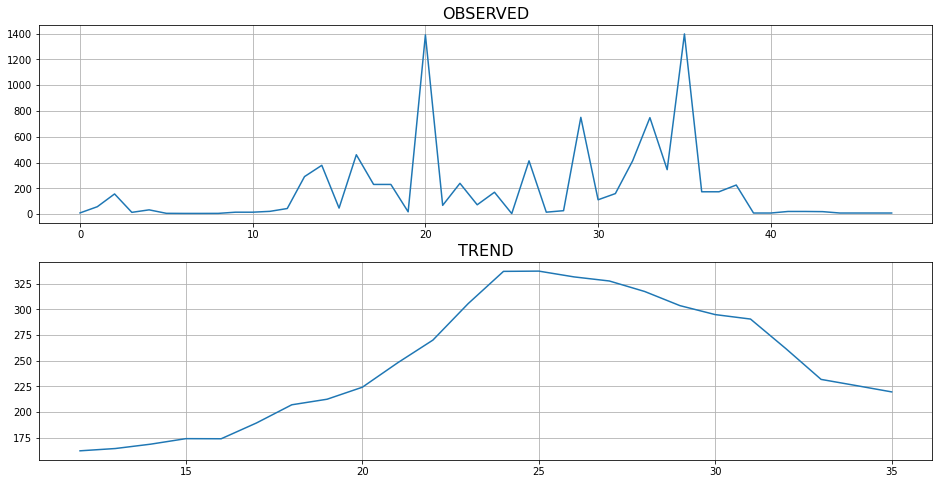

In [10]:
decompose_item_demand(df1,samples=48,period=24)

In [11]:
df1['HOUR'] = pd.to_datetime(df1['TIME']).dt.hour

In [12]:
df1.head()

,Unnamed: 0,ITEM_NUMBER,DATE,TIME,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON,HOUR
0,0,844600,8/14/13,8:40:14,2.85714,2013,8,33,14,0,3,8
1,1,844600,8/16/13,15:16:10,15.60000,2013,8,33,16,0,3,15
2,2,844600,8/16/13,15:19:22,15.60000,2013,8,33,16,0,3,15
3,3,844600,8/16/13,17:04:11,716.91429,2013,8,33,16,0,3,17
4,4,844600,8/16/13,17:09:59,153.14286,2013,8,33,16,0,3,17


In [13]:
df1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
df1.drop(['DATE','TIME'], axis=1, inplace=True)

In [15]:
df1.sort_values(by=["YEAR"]) 

,ITEM_NUMBER,SOLDUNITS,YEAR,MONTH,WEEK,DAY,IS_HOLIDAY,SEASON,HOUR
6420,844600,1.00000,2009,6,26,24,0,3,13
9107,844600,34.58824,2009,10,44,28,0,4,12
6419,844600,1.00000,2009,6,26,24,0,3,13
10681,844600,14.00000,2009,7,29,15,0,3,15
10680,844600,24.00000,2009,7,29,15,0,3,15
...,...,...,...,...,...,...,...,...,...
9759,844600,363.09041,2022,1,3,21,0,1,7
9760,844600,363.09041,2022,1,3,21,0,1,7
9761,844600,263.57397,2022,1,3,21,0,1,7
9743,844600,5.24932,2022,1,3,20,0,1,5


In [16]:
horizon=24*7
X = df1.drop('SOLDUNITS', axis=1)
y = df1['SOLDUNITS']

In [17]:
 #take last week of the dataset for validation
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [18]:
year = X_test['YEAR']
month = X_test['MONTH']
day = X_test['DAY']
actual_count = y_test

In [19]:
#create, train and do inference of the model
model = ltb.LGBMRegressor(random_state=42)

In [20]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [21]:
predictions = model.predict(X_test)

In [22]:
#calculate MAE
mae = np.round(mean_absolute_error(y_test, predictions), 3)

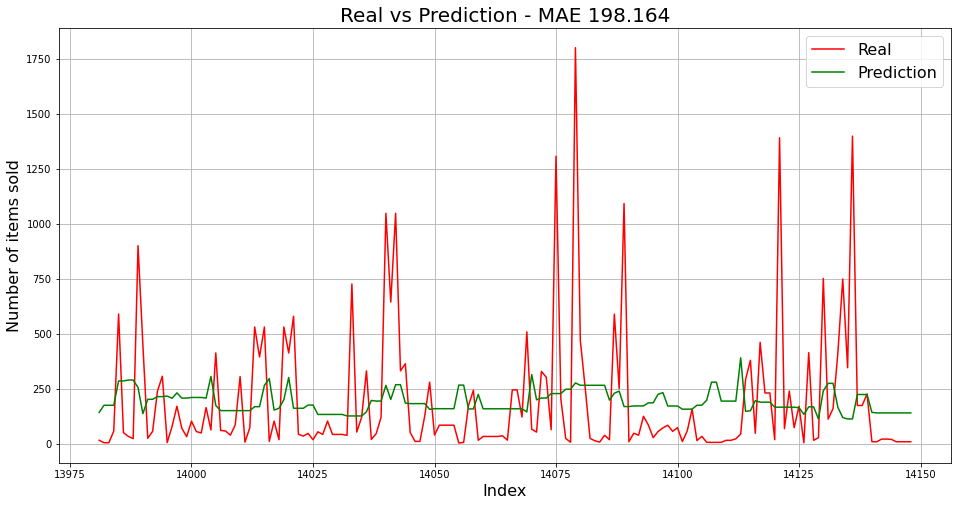

In [23]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(y_test, color='red')
plt.plot(pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('Index', fontsize=16)
plt.ylabel('Number of items sold', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

In [24]:
submission = pd.DataFrame({'Year':year,'Month':month,'Day':day,'Actual count':actual_count,'count': predictions})

In [25]:
#create a dataframe with the variable importances of the model
df_importances = pd.DataFrame({
    'feature': model.feature_name_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)



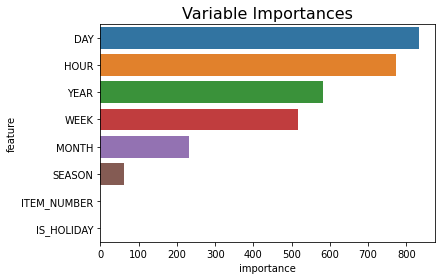

In [26]:
#plot variable importances of the model
plt.title('Variable Importances', fontsize=16)
sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
plt.show()

In [27]:
#create 1 week lag variable by shifting the target value for 1 week
df1['PREV_MONTH'] = df1['SOLDUNITS'].shift(24*7)

#drop NaNs after feature engineering
df1.dropna(how='any', axis=0, inplace=True)

In [28]:
horizon=24*7
X = df1.drop('SOLDUNITS', axis=1)
y = df1['SOLDUNITS']

In [29]:
 #take last week of the dataset for validation
X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

In [30]:
year = X_test['YEAR']
month = X_test['MONTH']
day = X_test['DAY']
actual_count = y_test

In [31]:
#create, train and do inference of the model
model = ltb.LGBMRegressor(random_state=42)

In [32]:
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
predictions = model.predict(X_test)

In [34]:
#calculate MAE
mae = np.round(mean_absolute_error(y_test, predictions), 3)

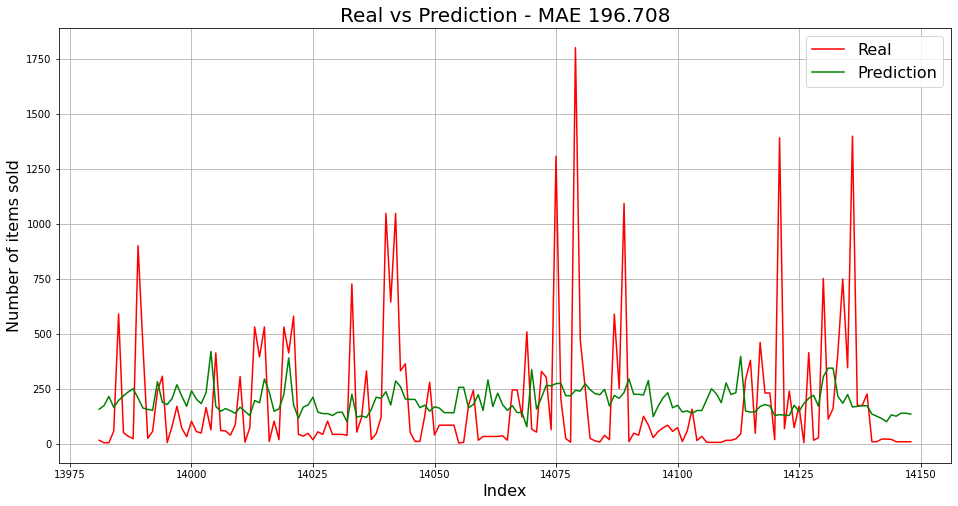

In [44]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.plot(X_test.index,y_test, color='red')
plt.plot(X_test.index,pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('Index', fontsize=16)
plt.ylabel('Number of items sold', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

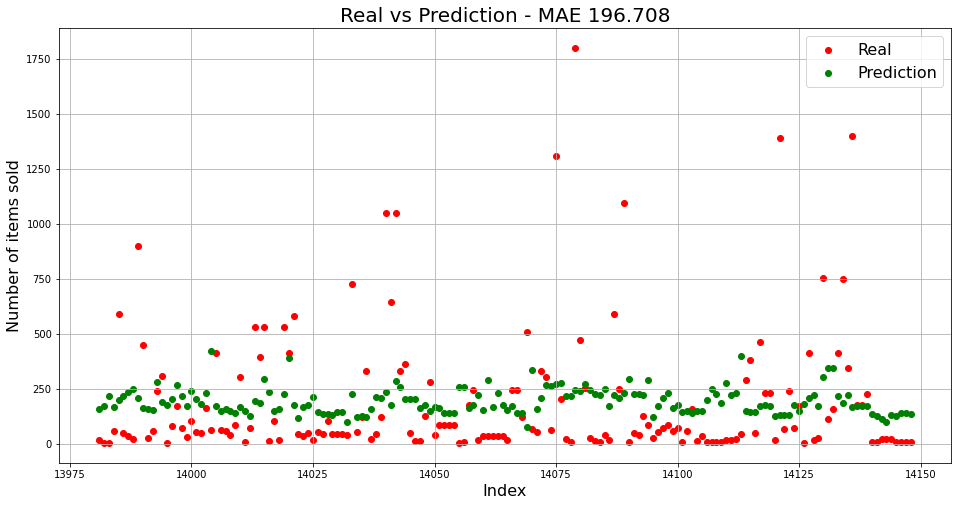

In [45]:
#plot reality vs prediction for the last week of the dataset
fig = plt.figure(figsize=(16,8))
plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
plt.scatter(X_test.index,y_test, color='red')
plt.scatter(X_test.index,pd.Series(predictions, index=y_test.index), color='green')
plt.xlabel('Index', fontsize=16)
plt.ylabel('Number of items sold', fontsize=16)
plt.legend(labels=['Real', 'Prediction'], fontsize=16)
plt.grid()
plt.show()

In [36]:
subLag = pd.DataFrame({'Year':year,'Month':month,'Day':day,'Actual count':actual_count,'count': predictions})

In [37]:
subLag.to_csv('preds.csv')

In [38]:
newData = pd.read_csv("../data/x_test.csv")

In [39]:
newPred = model.predict(newData)

In [40]:
year = newData['YEAR']
month = newData['MONTH']
day = newData['DAY']

In [41]:
newsub = pd.DataFrame({'Year':year,'Month':month,'Day':day,'count': newPred})

In [42]:
newsub.head()

,Year,Month,Day,count
0,2022,10,3,525.101135
1,2022,10,3,613.244350
2,2022,10,4,606.104345
3,2022,10,7,556.719781
4,2022,10,7,647.155350
